In [25]:
'''

Hier werden die vorverarbeiteten Beschwerde-Texte in numerische Vektoren umgewandelt.
Dazu nutzen wir:
# 1. TF-IDF: Gewichtung relevanter Begriffe basierend auf Häufigkeit und Seltenheit
# 2. Word2Vec: Erzeugung semantisch reicher Worteinbettungen

Die Ergebnisse werden wieder gespeichert um mit dem nächsten Notebook die Themen zu Extrahieren und Analysieren

'''

import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib  # Sichere Alternative zu pickle für das Speichern von Modellen
import json    # Zum Speichern von Metadaten

In [26]:
# Versuchen Daten einzulesen
try:
    processed_df = pd.read_csv('../data/processed_complaints_v2.csv')
    print("Datei gefunden.")
    print(f"Geladene Texte: {len(processed_df)}")
except FileNotFoundError:
    print("Fehler: Datei 'processed_complaints_v2.csv' nicht gefunden. Zuerst 1. Datenvorverarbeitung ausführen")

Datei gefunden.
Geladene Texte: 66806


In [27]:
# Korpus erstellen, NaN-Werte entfernen sowie Numpy Array zu Listen konvertieren
corpus = processed_df['processed_text'].dropna().tolist()

In [28]:
##########################################################
# 1. TF-IDF Vektorisierung
##########################################################
tfidf_vectorizer = TfidfVectorizer(
    max_features = 2000, # die 2000 Häufigsten Themen | Vielleicht höher stellen oder niedriger stellen
    min_df = 5,          # Begriffe müssen in mindestens 5 Dokumenten vorkommen
    max_df= 0.75,        # Begriffe, die mehr als 85% der Dokumente vorkommen
    ngram_range=(1, 2)   # Berücksichtigt Unigramme und Bigramme (not good statt good)
)


In [29]:
# Vektorisierung durchführen
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print(f"TF-IDF-Matrix erstellt mit Shape: {tfidf_matrix.shape}")
print("Beispielbegriffe:", list(tfidf_vectorizer.get_feature_names_out()[:10]))

TF-IDF-Matrix erstellt mit Shape: (66804, 2000)
Beispielbegriffe: ['ability', 'able', 'able get', 'able pay', 'absolutely', 'abuse', 'abusive', 'accept', 'acceptance', 'accepted']


In [30]:
# Speichern des TF-IDF Modells
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
np.save('../models/tfidf_matrix.npy', tfidf_matrix.toarray())

# Hier kam es zu einem Fehler mit einem Datentyp int64 um das Vokabular als JSON zu speichern. 
# Deshalb wird der Datentyp hier noch geändert. 

vocabulary_clean = {k: int(v) for k, v in tfidf_vectorizer.vocabulary_.items()}

# Speichern des Vokabulars als JSON für bessere Interpretierbarkeit
vocabulary = tfidf_vectorizer.vocabulary_
with open('../models/tfidf_vocabulary.json', 'w', encoding='utf-8') as f:
    json.dump(vocabulary_clean, f, ensure_ascii=False, indent=4)

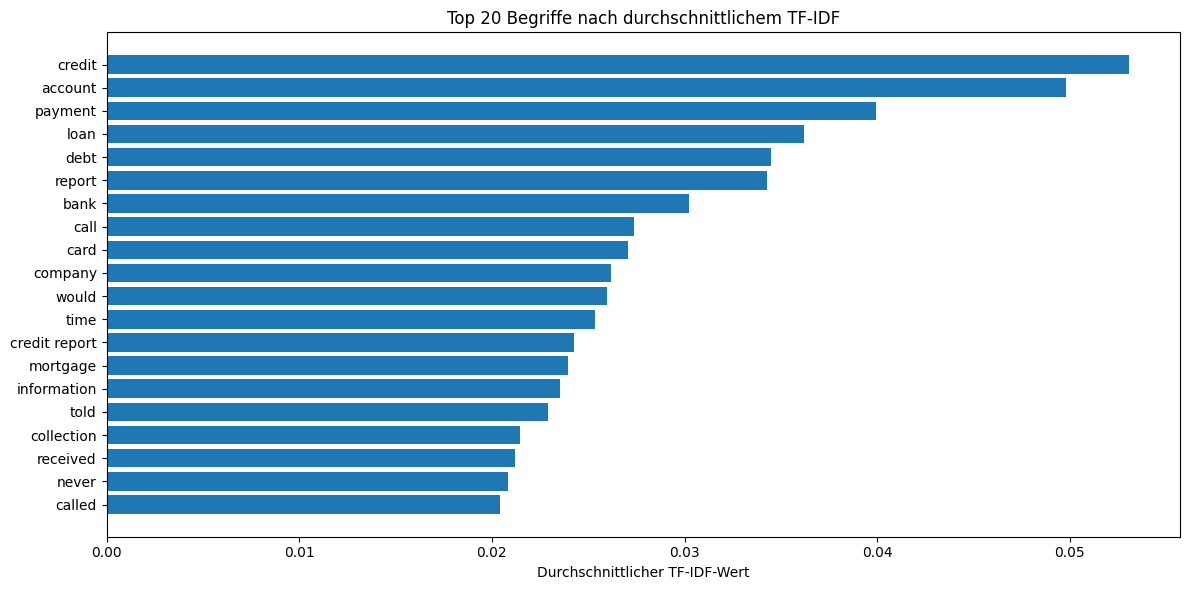

In [31]:
# Mittelwert je Spalte (= Begriff) berechnen
tfidf_means = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Begriffe holen
terms = tfidf_vectorizer.get_feature_names_out()

# Top 20 Begriffe mit höchstem durchschnittlichen TF-IDF-Wert
top_n = 20
top_indices = tfidf_means.argsort()[::-1][:top_n]
top_terms = [terms[i] for i in top_indices]
top_scores = [tfidf_means[i] for i in top_indices]

# Balkendiagramm erstellen
plt.figure(figsize=(12, 6))
plt.barh(top_terms[::-1], top_scores[::-1])  # Ohne [::-1] sind die niedrigsten Werte oben
plt.xlabel("Durchschnittlicher TF-IDF-Wert")
plt.title("Top 20 Begriffe nach durchschnittlichem TF-IDF")
plt.tight_layout()
plt.show()

In [ ]:
##########################################################
# 2. Bag-of-Words Vektorisierung für LDA
##########################################################

# CountVectorizer für Bag-of-Words erstellen
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.75,
    ngram_range=(1, 2)
)
